# Detect

##HM

In [ ]:
# -*- coding: utf-8 -*-
"""
Environmental Claim Consistency — H&M 2024 (with Program graph)

- Claims: extracted from brand reports (sentence + domain).
- Certifications: extracted from brand reports, checked against whitelist.
- Violations: extracted from lawsuit texts, using keyword matching.
- Programs/Initiatives: extracted from brand reports (rules + optional spaCy).
- SAFE if a claim has >=1 allowed certification; otherwise, if there are domain-matched
  violations, the claim is INCONSISTENT.

Graph edges:
    Brand -> Claim          (MAKES)
    Claim -> Cert           (COMPLIES_WITH)
    Brand -> Violation      (VIOLATES)
    Claim -> Violation      (VIOLATES, if domain matches)
    Brand -> Program        (PARTICIPATES_IN)
    Program -> Claim        (ASSERTS)     # program appears to assert/issue the claim
    Claim -> Program        (RELATES_TO)  # co-mention/related but not asserting
"""

from typing import List, Dict, Tuple, Optional, Set
import re
import networkx as nx

# ------------------------------------------------------------
# 0) INPUT SOURCES
# ------------------------------------------------------------
brand_name = "H&M"
brand_sources = ["/content/H&M_2024.txt"]
external_sources = ["/content/H&M_violation_2024.txt"]

# ------------------------------------------------------------
# 1) LOAD FILES
# ------------------------------------------------------------
source_texts: Dict[str, str] = {}
for path in brand_sources + external_sources:
    with open(path, "r", encoding="utf-8") as f:
        source_texts[path] = f.read()

# ------------------------------------------------------------
# 2) PREPROCESS
# ------------------------------------------------------------
def preprocess_text(text: str) -> str:
    text = re.sub(r'\bPage \d+\b|www\.hmgroup\.com', ' ', text, flags=re.I)
    text = text.replace("\u00ad", "")
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

cleaned_brand_texts = {p: preprocess_text(source_texts[p]) for p in brand_sources}
cleaned_external_texts = {p: preprocess_text(source_texts[p]) for p in external_sources}

# ------------------------------------------------------------
# 3) CONFIG — CLAIM/CERT/VIOLATION
# ------------------------------------------------------------
CLAIM_DOMAIN_RX: Dict[str, re.Pattern] = {
    "climate": re.compile(r'(net[-\s]?zero|greenhouse\s+gas|ghg|scope\s*1\s*&?\s*2|scope\s*3|decarbon|carbon)\b', re.I),
    "renewable_energy": re.compile(r'\brenewable\s+(?:electricity|energy)\b', re.I),
    "chemicals_water": re.compile(r'\b(zdhc|mrsl|wastewater|effluent|etp|chemical|water)\b', re.I),
    "wood_forest": re.compile(r'\b(FSC|PEFC|wood|forest|cellulosic|MMCF)\b', re.I),
    "materials_textile": re.compile(r'\b(material|textile|cotton|polyester|recycled|sustainably\s+sourced|Textile\s+Exchange|GOTS|RWS|RMS|GCS)\b', re.I),
    "circularity": re.compile(r'\b(circular|zero\s*waste|reuse|repair|recycling|close[-\s]*loop)\b', re.I),
}
VIOLATION_DOMAIN_RX = CLAIM_DOMAIN_RX

CERT_WHITELIST = {
    "climate": {"SBTI"},
    "renewable_energy": {"RE100"},
    "chemicals_water": {"ZDHC", "MRSL"},
    "wood_forest": {"FSC", "PEFC"},
    "materials_textile": {"GOTS", "RWS", "RMS", "GCS", "TEXTILE EXCHANGE"},
    "circularity": set(),
}
CERT_TOKENS = [
    r'\bSBTI\b', r'\bRE100\b', r'\bZDHC\b', r'\bMRSL\b',
    r'\bFSC\b', r'\bPEFC\b', r'\bGOTS\b', r'\bRWS\b',
    r'\bRMS\b', r'\bGCS\b', r'Textile\s+Exchange'
]
violation_keywords = [
    'misleading', 'false', 'untrue', 'removed', 'scrutiny',
    'lawsuit', 'alleging', 'investigation', 'high emissions',
    'failure to meet', 'being sued', 'misrepresentation'
]

# ------------------------------------------------------------
# 3b) CONFIG — PROGRAMS / INITIATIVES
# ------------------------------------------------------------
SMALL_WORDS: Set[str] = {"of", "for", "and", "the", "to", "in", "on", "by", "with", "&", "de", "la", "le", "du"}
BAD_STARTERS: Set[str] = {"and", "or", "but", "for", "to", "which", "that", "as", "of", "at", "in", "on", "by", "with", "from"}

# Seeds (no bare "Foundation")
KNOWN_PROGRAMS: Set[str] = {
    "Apparel Impact Institute", "LEAF Coalition", "Frontier",
    "Textile Genesis", "Better Cotton", "WWF Water Risk Filter",
    "UN Women India", "Textile Industry Coalition", "Looper Textile Co", "Syre",
    "Science Based Targets initiative", "RE100",
}

VERB_ANCHORS = re.compile(
    r"\b(aims|targets|commits|pledges|claims|ensures|delivers|promises|will|plans|seeks|enables|"
    r"achieve|reduce|cut|source|use|switch|reach|meet|comply)\b",
    re.I,
)

PROGRAM_ANCHOR_SUFFIX = r"(Institute|Coalition|Alliance|Platform|Program(?:me)?|Initiative|Venture|Project|Consortium|Pledge|Campaign|Challenge|Roadmap|Taskforce|Partnership)\b"
PROGRAM_ANCHOR_PREFIX = r"(initiative|project|program(?:me)?|campaign|platform|alliance|coalition|consortium|pledge|venture|challenge|roadmap|taskforce|partnership)"

rx_prog_suffix = re.compile(r"([A-Z][\w&'\-]*(?:\s+[A-Z][\w&'\-]*){0,6})\s+" + PROGRAM_ANCHOR_SUFFIX, re.U)
rx_prog_prefix = re.compile(
    PROGRAM_ANCHOR_PREFIX + r"\s+(?:called|named|titled|“|\"|')?"
    r"([A-Z][^\"”'\.:;,\-\n]{2,120}?)\s*(?=(?:\b(?:to|for|which|that|and|with|by|at|in|on|from)\b|[\.:\;,\-\"”']))",
    re.I
)

# ------------------------------------------------------------
# 4) HELPERS
# ------------------------------------------------------------
def split_sentences(text: str) -> List[str]:
    return re.split(r'(?<=[\.\!\?])\s+', text)

def classify_claim_domain(sentence: str) -> Optional[str]:
    for dom, rx in CLAIM_DOMAIN_RX.items():
        if rx.search(sentence):
            return dom
    return None

def classify_violation_domain(sentence: str) -> Optional[str]:
    for dom, rx in VIOLATION_DOMAIN_RX.items():
        if rx.search(sentence):
            return dom
    return None

def extract_claims(text: str):
    out = []
    for s in split_sentences(text):
        sent = s.strip()
        if not sent:
            continue
        dom = classify_claim_domain(sent)
        if dom:
            out.append((sent, dom))
    return out

def extract_certs(text: str):
    found = set()
    for pat in CERT_TOKENS:
        for m in re.finditer(pat, text, flags=re.I):
            tok = m.group(0)
            if re.search(r'Textile\s+Exchange', tok, re.I):
                found.add("TEXTILE EXCHANGE")
            else:
                found.add(tok.upper())
    return found

def extract_violations(text: str):
    out, seen = [], set()
    for s in split_sentences(text):
        sent = s.strip()
        if not sent:
            continue
        if any(re.search(r'\b' + re.escape(kw) + r'\b', sent, re.I) for kw in violation_keywords):
            key = re.sub(r'\s+', ' ', sent.lower()).strip()
            if key not in seen:
                seen.add(key)
                out.append(sent)
    return out

# ---------- program helpers ----------
def clean_title(t: str) -> str:
    t = t.strip().strip('\"\'"“”‘’.,;:()[]{}')
    t = re.sub(r"\s*[\(\[\{].*$", "", t)
    t = re.sub(r"[,:;—–-]\s*$", "", t)
    t = re.sub(r"\s+", " ", t)
    return t

def strip_possessive(s: str) -> str:
    return re.sub(r"(?:’s|'s)\b", "", s).strip()

def cut_trailing_context(s: str) -> str:
    return re.split(r"\s(?:to|for|which|that|and|with|by|at|in|on|from)\b", s)[0]

def canonicalize_program_name(name: str) -> str:
    name = strip_possessive(name)
    name = clean_title(name)
    name = re.sub(r"\bBetter Cotton Initiative\b", "Better Cotton", name, flags=re.I)
    name = re.sub(r"\bBCI\b", "Better Cotton", name, flags=re.I)
    return name

def looks_like_name(name: str) -> bool:
    if not name or len(name) < 2:
        return False
    if re.search(r"\bfoundation\b", name, flags=re.I):
        if not re.search(r"\b(initiative|program(?:me)?|project|coalition|alliance|platform|consortium|pledge|campaign|venture|challenge|roadmap|taskforce|partnership)\b", name, flags=re.I):
            return False
    if name.strip().lower() in {"initiative","program","programme","project","coalition","alliance","platform","pledge","campaign"}:
        return False
    first = name.split()[0].lower()
    if first in BAD_STARTERS:
        return False
    tokens = name.split()
    core = [t for t in tokens if t.lower() not in SMALL_WORDS]
    if not core:
        return False
    good = sum(1 for t in core if re.match(r"^[A-Z][\w&'\-]+$|^[A-Z0-9]{2,}$", t))
    return good >= max(1, len(core) // 2)

def dedup_case_insensitive(items):
    seen = {}
    for x in items:
        k = canonicalize_program_name(x)
        k_key = re.sub(r"[^\w& ]+", "", k).casefold()
        if k_key not in seen:
            seen[k_key] = k
    return set(seen.values())

def extract_programs_rules(text: str):
    found = set()
    # seeds
    for name in KNOWN_PROGRAMS:
        if re.search(r"\b" + re.escape(name) + r"\b", text, flags=re.I):
            found.add(name)
    # suffix-anchored (e.g., Apparel Impact Institute)
    for m in rx_prog_suffix.finditer(text):
        candidate = f"{clean_title(m.group(1))} {m.group(2)}"
        candidate = canonicalize_program_name(candidate)
        if 2 <= len(candidate) <= 120 and len(candidate.split()) <= 10 and looks_like_name(candidate):
            found.add(candidate)
    # prefix-anchored (e.g., the initiative "Harvesting the Future")
    for m in rx_prog_prefix.finditer(text):
        candidate = cut_trailing_context(clean_title(m.group(2)))
        candidate = canonicalize_program_name(candidate)
        if 2 <= len(candidate) <= 120 and len(candidate.split()) <= 10 and looks_like_name(candidate):
            found.add(candidate)
    found = {p for p in found if looks_like_name(p)}
    return dedup_case_insensitive(found)

def setup_spacy():
    try:
        import spacy
        return spacy.load("en_core_web_sm")
    except Exception:
        return None

def extract_programs_ner(text: str, known_programs: set, nlp):
    if nlp is None:
        return set()
    programs = set()
    from spacy.matcher import PhraseMatcher
    doc = nlp(text)
    phrase = PhraseMatcher(nlp.vocab, attr="LOWER")
    patterns = [nlp.make_doc(p) for p in known_programs]
    if patterns:
        phrase.add("PROGRAM_SEEDS", patterns)
        for _, start, end in phrase(doc):
            programs.add(doc[start:end].text)
    for ent in doc.ents:
        if ent.label_ in ("ORG", "WORK_OF_ART", "PRODUCT", "EVENT"):
            if re.search(PROGRAM_ANCHOR_SUFFIX, ent.text, re.I):
                programs.add(ent.text)
    cleaned = set()
    for p in programs:
        p2 = canonicalize_program_name(p)
        if 2 <= len(p2) <= 120 and looks_like_name(p2):
            cleaned.add(p2)
    return dedup_case_insensitive(cleaned)

def find_first_domain_span(sentence: str):
    best = (None, None, None)
    for dom, rx in CLAIM_DOMAIN_RX.items():
        m = rx.search(sentence)
        if m and (best[1] is None or m.start() < best[1]):
            best = (dom, m.start(), m.end())
    return best

def program_asserts_claim(sentence: str, program_name: str, nlp=None) -> bool:
    m_name = re.search(r"\b" + re.escape(program_name) + r"\b", sentence, flags=re.I)
    if not m_name:
        return False
    dom, dom_s, _ = find_first_domain_span(sentence)
    if dom_s is None:
        return False
    # simple heuristic: Program mention precedes domain phrase and a verb anchor appears in between
    if m_name.start() <= dom_s:
        between = sentence[m_name.end():dom_s]
        if VERB_ANCHORS.search(between):
            return True
    # optional spaCy subject-verb heuristic
    if nlp is not None:
        try:
            doc = nlp(sentence)
            spans = [ent for ent in doc.ents if ent.text.lower() == program_name.lower()]
            for sp in spans:
                head = sp.root.head
                if head.pos_ == "VERB":
                    is_subj = any(
                        (child.dep_ in ("nsubj", "nsubjpass")) and (sp.root in list(child.subtree) or child == sp.root)
                        for child in head.children
                    )
                    if is_subj and dom is not None:
                        return True
        except Exception:
            pass
    return False

# ------------------------------------------------------------
# 5) RUN EXTRACTION
# ------------------------------------------------------------
nlp = setup_spacy()  # Optional, may be None

brand_entities: Dict[str, Dict] = {}
external_entities: Dict[str, list] = {}
all_claims: List[Tuple[str, str, str]] = []
all_certs: Set[str] = set()
all_violations: List[Tuple[str, str]] = []
all_programs: Set[str] = set()

for src, txt in cleaned_brand_texts.items():
    claims = extract_claims(txt)
    certs = extract_certs(txt)
    programs_r = extract_programs_rules(txt)
    programs_n = extract_programs_ner(txt, KNOWN_PROGRAMS, nlp)
    programs = dedup_case_insensitive(programs_r | programs_n)

    brand_entities[src] = {"claims": claims, "certs": certs, "programs": programs, "text": txt}
    all_claims += [(c[0], c[1], src) for c in claims]
    all_certs |= certs
    all_programs |= programs

for src, txt in cleaned_external_texts.items():
    violations = extract_violations(txt)
    external_entities[src] = violations
    all_violations += [(v, src) for v in violations]

print("=== Extracted Entities (H&M 2024) ===")
print("Claims:", len(all_claims))
print("Certifications:", sorted(all_certs))
print("Programs/Initiatives:", sorted(all_programs))
print("Violations:", len(all_violations))
for i, (v, s) in enumerate(all_violations[:20], 1):
    print(f"  Violation_{i}: {v[:160]}{'...' if len(v)>160 else ''} (src={s})")

# ------------------------------------------------------------
# 6) BUILD KG
# ------------------------------------------------------------
G = nx.DiGraph()
G.add_node(brand_name, type="Brand")
for src in brand_sources + external_sources:
    G.add_node(src, type="Source")

# Claim nodes
claim_nodes = {}
for i, (sent, dom, src) in enumerate(all_claims, 1):
    cid = f"Claim_{i}"
    claim_nodes[cid] = {"text": sent, "domain": dom, "src": src}
    G.add_node(cid, type="Claim", description=sent, domain=dom)
    G.add_edge(brand_name, cid, relation="MAKES")
    G.add_edge(cid, src, relation="APPEARS_IN")

# Certification nodes
whitelist_universe = set().union(*CERT_WHITELIST.values())
for c in sorted(all_certs):
    if c in whitelist_universe:
        G.add_node(c, type="Certification")

# Claim -> Certification
for cid, info in claim_nodes.items():
    dom, src = info["domain"], info["src"]
    allowed = CERT_WHITELIST.get(dom, set())
    for c in (brand_entities[src]["certs"] & allowed):
        G.add_edge(cid, c, relation="COMPLIES_WITH")

# Violation nodes
violation_nodes = {}
for i, (vtext, src) in enumerate(all_violations, 1):
    vid = f"Violation_{i}"
    violation_nodes[vid] = {"text": vtext, "src": src}
    G.add_node(vid, type="Violation", description=vtext)
    G.add_edge(brand_name, vid, relation="VIOLATES")
    G.add_edge(vid, src, relation="APPEARS_IN")

# Claim -> Violation (domain match)
for cid, cinfo in claim_nodes.items():
    cdom = cinfo["domain"]
    for vid, vinfo in violation_nodes.items():
        vdom = classify_violation_domain(vinfo["text"])
        if vdom == cdom:
            G.add_edge(cid, vid, relation="VIOLATES")

# ---------------- Program nodes + edges ----------------
REL_ASSERTS = "ASSERTS"
REL_RELATES = "RELATES_TO"

program_nodes = {}
for p in sorted(all_programs):
    pid = f"Program::{p}"
    program_nodes[pid] = {"label": p}
    G.add_node(pid, type="Program", label=p)
    G.add_edge(brand_name, pid, relation="PARTICIPATES_IN")
    # provenance to brand sources mentioning it
    for src, meta in brand_entities.items():
        if re.search(r"\b" + re.escape(p) + r"\b", meta.get("text", ""), flags=re.I):
            G.add_edge(pid, src, relation="APPEARS_IN")

# Link Claim <-> Program
for cid, info in claim_nodes.items():
    text = info["text"]
    for pid, meta in program_nodes.items():
        name = meta["label"]
        if re.search(r"\b" + re.escape(name) + r"\b", text, flags=re.I):
            if program_asserts_claim(text, name, nlp):
                if not G.has_edge(pid, cid):
                    G.add_edge(pid, cid, relation=REL_ASSERTS)
            else:
                if not G.has_edge(cid, pid):
                    G.add_edge(cid, pid, relation=REL_RELATES)

print("\nKG Stats: Nodes =", G.number_of_nodes(), "Edges =", G.number_of_edges())

# ------------------------------------------------------------
# 7) CONSISTENCY REPORT
# ------------------------------------------------------------
def detect_inconsistencies(G):
    paths, score, report = [], 0, []
    vio_sources = {
        v: [t for _, t, ed in G.out_edges(v, data=True) if ed.get("relation") == "APPEARS_IN"]
        for v, d in G.nodes(data=True) if d.get("type") == "Violation"
    }
    for cid, cdata in [(n, d) for n, d in G.nodes(data=True) if d.get("type") == "Claim"]:
        claim_text, domain = cdata["description"], cdata["domain"]
        allowed_certs = sorted(list(CERT_WHITELIST.get(domain, set())))
        evidence_certs = [
            tgt for _, tgt, ed in G.out_edges(cid, data=True)
            if ed.get("relation") == "COMPLIES_WITH" and tgt in allowed_certs
        ]
        safe = len(evidence_certs) > 0
        vios = [v for _, v, ed in G.out_edges(cid, data=True) if ed.get("relation") == "VIOLATES"]
        inconsistent = (not safe) and len(vios) > 0
        if inconsistent:
            score += 1
            paths.append([f"Brand::{brand_name}", cid, vios[0]])

        report.append({
            "claim_node": cid,
            "claim_text": claim_text,
            "domain": domain,
            "allowed_certs": allowed_certs,
            "evidence_certs": evidence_certs,
            "safe": safe,
            "inconsistent": inconsistent,
            "violations": [{
                "violation_node": v,
                "violation_snippet": G.nodes[v]["description"][:200],
                "sources": vio_sources.get(v, [])
            } for v in vios],
            "paths": [[f"Brand::{brand_name}", cid, v] for v in vios]
        })
    return paths, score, report

paths, score, report = detect_inconsistencies(G)

print("\n=== CONSISTENCY REPORT ===")
for r in report[:50]:  # tránh in quá dài
    print(f"\nCLAIM NODE: {r['claim_node']}")
    print(f"  Domain          : {r['domain']}")
    print(f"  Claim (full)    : {r['claim_text']}")
    print(f"  Allowed certs   : {r['allowed_certs']}")
    print(f"  Evidence certs  : {r['evidence_certs']}")
    print(f"  SAFE?           : {r['safe']}")
    print(f"  INCONSISTENT?   : {r['inconsistent']}")
    if r["violations"]:
        print("  Violations (from lawsuit):")
        for v in r["violations"]:
            print(f"    - {v['violation_node']} | {v['violation_snippet']}...")
            print(f"      Sources: {v['sources']}")
    if (not r["safe"]) and r["paths"]:
        print("  Paths:")
        for p in r["paths"]:
            print(f"    - {' -> '.join(p)}")

print("\nDetected Inconsistency Paths:")
for r in report:
    if (not r["safe"]) and r["inconsistent"]:
        for p in r["paths"]:
            print(" -> ".join(p))
print("Inconsistency Score:", score)

# (Optional) Inconsistency score by domain
from collections import Counter
domain_counts = Counter()
for r in report:
    if (not r["safe"]) and r["inconsistent"]:
        domain_counts[r["domain"] or "unknown"] += 1
print("\n=== INCONSISTENCY SCORE BY DOMAIN ===")
if domain_counts:
    for dom, cnt in sorted(domain_counts.items(), key=lambda x: (-x[1], x[0])):
        print(f"  - {dom}: {cnt}")
else:
    print("  (no inconsistencies detected)")


=== Extracted Entities (H&M 2024) ===
Claims: 239
Certifications: ['FSC', 'MRSL', 'RE100', 'RWS', 'SBTI', 'TEXTILE EXCHANGE', 'ZDHC']
Programs/Initiatives: ['Apparel Impact Institute', 'Better Cotton', 'Circular Design Consortium', 'Ellen MacArthur Foundation Re-model Initiative', 'Environmental Pollution Programme', 'Frontier', 'Future Supplier Initiative', 'Global Reporting Initiative', 'Green Fashion Initiative', 'H&M Group Green Fashion Initiative', 'H&M Group works', 'Harvesting the Future – Cotton', 'LEAF Coalition', 'Looper Textile Co', 'Polyester Challenge', 'RE100', 'Recycled Polyester Challenge', 'Science Based Targets initiative', 'Syre', 'Textile Genesis', 'Textile Industry Coalition', 'UN Women India', 'called STEP', 'was 97']
Violations: 12
  Violation_1: H&M is Being Sued For “Misleading” Sustainability Marketing. (src=/content/H&M_violation_2024.txt)
  Violation_2: H&M is being sued for '“false” and “misleading” sustainability marketing. (src=/content/H&M_violation_2024

In [ ]:
!pip install -q pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00


In [ ]:
# -*- coding: utf-8 -*-
"""
Code to extract a representative subset of the KG and visualize with PyVis.
This assumes the previous code has run, and G (NetworkX DiGraph) exists,
along with report from detect_inconsistencies.

Focus: Showcase key aspects like SAFE/INCONSISTENT claims, linked to certs/violations/programs.
Select: Brand, 2 inconsistent claims (circularity), 2 safe claims (different domains),
linked violations, certs, 1-2 programs, minimal sources if directly connected.

Subset criteria:
- Brand node
- Inconsistent claims: First 2 from report (e.g., Claim_5, Claim_141)
- Safe claims: Claim_1 (chemicals_water, with certs), Claim_7 (climate, with SBTi)
- Connected violations: Violation_5, Violation_6 (linked to inconsistent)
- Connected certs: ZDHC, MRSL (from Claim_1), SBTI (from Claim_7)
- Programs: Better Cotton (common), Science Based Targets initiative (relates to climate)
- Edges: Only those in subset

Node titles: Short labels (e.g., "Claim_5: circularity (INCONSISTENT)", "Violation_5")
No long content in labels; full desc available in hover if needed.

Visualize with PyVis: Interactive HTML, nodes colored by type, edges labeled by relation.
"""

import networkx as nx
from pyvis.network import Network

# Step 1: Select representative nodes (same as before)
# case: small-sized graph
'''# From report, get inconsistent claims
inconsistent_claims = [r['claim_node'] for r in report if r['inconsistent']]
# Pick first 2 inconsistent (circularity examples)
selected_inconsistent = inconsistent_claims[:2]  # e.g., Claim_5, Claim_141

# Safe claims: Manually pick diverse from early report
selected_safe = ['Claim_1', 'Claim_7']  # chemicals_water (with certs), climate (with SBTi)

# Brand
brand = brand_name

# Connected violations: From edges to selected claims
violations = set()
for claim in selected_inconsistent + selected_safe:
    violations.update([tgt for src, tgt, ed in G.out_edges(claim, data=True) if ed['relation'] == 'VIOLATES'])

# Connected certs
certs = set()
for claim in selected_inconsistent + selected_safe:
    certs.update([tgt for src, tgt, ed in G.out_edges(claim, data=True) if ed['relation'] == 'COMPLIES_WITH'])

# Programs: Pick 2 representative, check connections
programs = ['Program::Better Cotton', 'Program::Science Based Targets initiative']
# Filter to those connected to selected claims
connected_programs = set()
for prog in programs:
    for claim in selected_inconsistent + selected_safe:
        if G.has_edge(prog, claim) or G.has_edge(claim, prog):
            connected_programs.add(prog)

# Sources: Minimal, only if directly connected (e.g., to showcase APPEARS_IN), pick one brand source
sources = set()
for node in selected_inconsistent + selected_safe + list(violations):
    sources.update([tgt for src, tgt, ed in G.out_edges(node, data=True) if ed['relation'] == 'APPEARS_IN'])
sources = list(sources)[:1]  # Limit to 1 for small subset

# All selected nodes
selected_nodes = [brand] + selected_inconsistent + selected_safe + list(violations) + list(certs) + list(connected_programs) + list(sources)'''

# case: medium-sized graph
'''# Step 1: Select representative nodes
inconsistent_claims = [r['claim_node'] for r in report if r['inconsistent']]
selected_inconsistent = inconsistent_claims[:5]  # Increased from 2

selected_safe = ['Claim_1', 'Claim_7', 'Claim_15', 'Claim_19', 'Claim_21']  # Increased from 2, diverse domains

brand = brand_name

violations = set()
for claim in selected_inconsistent + selected_safe:
    violations.update([tgt for src, tgt, ed in G.out_edges(claim, data=True) if ed['relation'] == 'VIOLATES'])

certs = set()
for claim in selected_inconsistent + selected_safe:
    certs.update([tgt for src, tgt, ed in G.out_edges(claim, data=True) if ed['relation'] == 'COMPLIES_WITH'])

programs = ['Program::Better Cotton', 'Program::Science Based Targets initiative', 'Program::RE100', 'Program::Apparel Impact Institute', 'Program::Frontier']  # Increased from 2
connected_programs = set()
for prog in programs:
    for claim in selected_inconsistent + selected_safe:
        if G.has_edge(prog, claim) or G.has_edge(claim, prog):
            connected_programs.add(prog)

sources = set()
for node in selected_inconsistent + selected_safe + list(violations):
    sources.update([tgt for src, tgt, ed in G.out_edges(node, data=True) if ed['relation'] == 'APPEARS_IN'])
sources = list(sources)[:3]  # Increased from 1

selected_nodes = [brand] + selected_inconsistent + selected_safe + list(violations) + list(certs) + list(connected_programs) + list(sources)
'''
# case: large-sized graph
'''# Step 1: Select representative nodes (large size)
inconsistent_claims = [r['claim_node'] for r in report if r['inconsistent']]
selected_inconsistent = inconsistent_claims[:10]  # 10 inconsistent claims (e.g., more circularity examples)

selected_safe = ['Claim_1', 'Claim_7', 'Claim_15', 'Claim_19', 'Claim_21', 'Claim_25', 'Claim_28', 'Claim_32', 'Claim_34', 'Claim_37']  # 10 safe claims (added more from renewable_energy, climate, materials_textile)

brand = brand_name

violations = set()
for claim in selected_inconsistent + selected_safe:
    violations.update([tgt for src, tgt, ed in G.out_edges(claim, data=True) if ed['relation'] == 'VIOLATES'])

certs = set()
for claim in selected_inconsistent + selected_safe:
    certs.update([tgt for src, tgt, ed in G.out_edges(claim, data=True) if ed['relation'] == 'COMPLIES_WITH'])

programs = [
    'Program::Better Cotton', 'Program::Science Based Targets initiative', 'Program::RE100',
    'Program::Apparel Impact Institute', 'Program::Frontier', 'Program::LEAF Coalition',
    'Program::Textile Genesis', 'Program::Looper Textile Co', 'Program::Syre', 'Program::Polyester Challenge'
]  # 10 programs (expanded from extracted list, focusing on connected ones)
connected_programs = set()
for prog in programs:
    for claim in selected_inconsistent + selected_safe:
        if G.has_edge(prog, claim) or G.has_edge(claim, prog):
            connected_programs.add(prog)

sources = set()
for node in selected_inconsistent + selected_safe + list(violations):
    sources.update([tgt for src, tgt, ed in G.out_edges(node, data=True) if ed['relation'] == 'APPEARS_IN'])
sources = list(sources)[:5]  # Up to 5 sources (more provenance without full set)

selected_nodes = [brand] + selected_inconsistent + selected_safe + list(violations) + list(certs) + list(connected_programs) + list(sources)'''

# case: Xlarge-sized graph
# Step 1: Select representative nodes (extra large size)
inconsistent_claims = [r['claim_node'] for r in report if r['inconsistent']]
selected_inconsistent = inconsistent_claims  # All inconsistent claims (~22 from output)

# Select ~20 safe claims (manually picked from report, covering all domains)
selected_safe = [
    'Claim_1', 'Claim_2', 'Claim_3', 'Claim_4', 'Claim_6', 'Claim_7', 'Claim_8', 'Claim_9', 'Claim_10',
    'Claim_11', 'Claim_12', 'Claim_13', 'Claim_14', 'Claim_15', 'Claim_16', 'Claim_17', 'Claim_18',
    'Claim_19', 'Claim_20', 'Claim_21', 'Claim_22', 'Claim_23', 'Claim_24', 'Claim_25', 'Claim_26',
    'Claim_27', 'Claim_28', 'Claim_29', 'Claim_30'  # Extend as needed up to available SAFE claims
][:20]  # Cap at 20 for "extra large" without full exhaustion

brand = brand_name

violations = set()
for claim in selected_inconsistent + selected_safe:
    violations.update([tgt for src, tgt, ed in G.out_edges(claim, data=True) if ed['relation'] == 'VIOLATES'])

certs = set()
for claim in selected_inconsistent + selected_safe:
    certs.update([tgt for src, tgt, ed in G.out_edges(claim, data=True) if ed['relation'] == 'COMPLIES_WITH'])

# All extracted programs from output (no connection filter for max density)
programs = [
    'Program::Apparel Impact Institute', 'Program::Better Cotton', 'Program::Circular Design Consortium',
    'Program::Ellen MacArthur Foundation Re-model Initiative', 'Program::Environmental Pollution Programme',
    'Program::Frontier', 'Program::Future Supplier Initiative', 'Program::Global Reporting Initiative',
    'Program::Green Fashion Initiative', 'Program::H&M Group Green Fashion Initiative', 'Program::H&M Group works',
    'Program::Harvesting the Future – Cotton', 'Program::LEAF Coalition', 'Program::Looper Textile Co',
    'Program::Polyester Challenge', 'Program::RE100', 'Program::Recycled Polyester Challenge',
    'Program::Science Based Targets initiative', 'Program::Syre', 'Program::Textile Genesis',
    'Program::Textile Industry Coalition', 'Program::UN Women India', 'Program::called STEP', 'Program::was 97'
]
connected_programs = set(programs)  # Include all, even if not connected (for density/testing)

sources = set()
for node in selected_inconsistent + selected_safe + list(violations):
    sources.update([tgt for src, tgt, ed in G.out_edges(node, data=True) if ed['relation'] == 'APPEARS_IN'])
sources = list(sources)  # All sources (no limit)

selected_nodes = [brand] + selected_inconsistent + selected_safe + list(violations) + list(certs) + list(connected_programs) + list(sources)

# Step 2: Create subgraph
subG = G.subgraph(selected_nodes)

# Step 3: Print subset (node titles and edges)
print("=== Representative KG Subset ===")
print("Nodes (titles):")
node_titles = {}
for n in subG.nodes():
    data = subG.nodes[n]
    node_type = data.get('type', 'Unknown')
    if node_type == 'Brand':
        title = n
    elif node_type == 'Claim':
        domain = data.get('domain', '')
        status = 'INCONSISTENT' if n in inconsistent_claims else 'SAFE'
        title = f"{n}: {domain} ({status})"
    elif node_type == 'Violation':
        title = n
    elif node_type == 'Certification':
        title = n
    elif node_type == 'Program':
        title = data.get('label', n.split('::')[-1])
    elif node_type == 'Source':
        title = n.split('/')[-1]  # Short filename
    else:
        title = n
    node_titles[n] = title
    print(f"- {title} ({node_type})")

print("\nEdges:")
for src, tgt, data in subG.edges(data=True):
    rel = data.get('relation', 'UNKNOWN')
    src_title = node_titles[src]
    tgt_title = node_titles[tgt]
    print(f"- {src_title} -> {tgt_title} ({rel})")

# Step 4: Visualize with PyVis (updated styles)
net = Network(notebook=True, height="750px", width="100%", directed=True, bgcolor="#ffffff", font_color="#000000")

# Pastel colors for professionalism
type_colors = {
    'Brand': '#FFDAB9',  # Peach puff
    'Claim': '#ADD8E6',  # Light blue
    'Certification': '#90EE90',  # Light green
    'Violation': '#FFB6C1',  # Light pink
    'Program': '#DDA0DD',  # Plum
    'Source': '#D3D3D3'   # Light gray
}

for n, data in subG.nodes(data=True):
    node_type = data.get('type', 'Unknown')
    color = type_colors.get(node_type, '#FFFFFF')
    label = node_titles[n]
    title_hover = data.get('description', '') or data.get('label', '') or label  # Hover for full if available
    net.add_node(n, label=label, title=title_hover, color=color, shape='dot' if node_type != 'Claim' else 'square')

for src, tgt, data in subG.edges(data=True):
    rel = data.get('relation', 'UNKNOWN')
    net.add_edge(src, tgt, label=rel, arrows='to', title=rel)

# Physics and font options (Times New Roman)
net.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 14,
      "face": "times new roman"
    }
  },
  "edges": {
    "font": {
      "size": 12,
      "face": "times new roman",
      "align": "horizontal"
    },
    "smooth": false
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -5000,
      "centralGravity": 0.3,
      "springLength": 200,
      "springConstant": 0.04,
      "damping": 0.09
    },
    "minVelocity": 0.75
  }
}
""")

# Show in Colab (saves to HTML, can download for thesis)
net.show("kg_subset.html")
print("\nUpdated visualization saved to 'kg_subset.html'. Download and include in thesis.")

=== Representative KG Subset ===
Nodes (titles):
- Claim_166: circularity (INCONSISTENT) (Claim)
- Claim_194: circularity (INCONSISTENT) (Claim)
- Claim_163: circularity (INCONSISTENT) (Claim)
- UN Women India (Program)
- Claim_193: circularity (INCONSISTENT) (Claim)
- MRSL (Certification)
- Frontier (Program)
- RE100 (Certification)
- Claim_19: renewable_energy (SAFE) (Claim)
- RE100 (Program)
- Claim_5: circularity (INCONSISTENT) (Claim)
- Green Fashion Initiative (Program)
- Polyester Challenge (Program)
- Future Supplier Initiative (Program)
- Claim_21: materials_textile (SAFE) (Claim)
- Claim_14: climate (SAFE) (Claim)
- Claim_174: circularity (INCONSISTENT) (Claim)
- Claim_10: chemicals_water (SAFE) (Claim)
- Claim_196: circularity (INCONSISTENT) (Claim)
- Claim_164: circularity (INCONSISTENT) (Claim)
- Claim_175: circularity (INCONSISTENT) (Claim)
- Science Based Targets initiative (Program)
- Claim_145: circularity (INCONSISTENT) (Claim)
- H&M_2024.txt (Source)
- Claim_12: rene

##Other brands

In [ ]:
# -*- coding: utf-8 -*- For HM 2022-2023, Shein, Zara, Uniqlo
"""
Environmental Claim Consistency — Single Brand + Programs (multi‑source violations)

Run one brand at a time.
- Brand can have 0–N report files (`brand_sources`).
- Brand can have 2–3+ violation files (`external_sources`) → violations deduped with source provenance.
- NEW: Extract Program/Initiative nodes (hybrid rules + optional spaCy NER) and link them:
    Brand -> Program (PARTICIPATES_IN)
    Claim -> Program (RELATES_TO)  [co‑mention/related]
    Program -> Claim (ASSERTS)     [program appears to assert/issue the claim]
- 'Foundation' alone is NOT treated as a program (unless anchored like 'X Foundation Initiative').

SAFE rule: a Claim is SAFE if it has ≥1 allowed certification for its domain; otherwise, if there are domain‑matched violations → INCONSISTENT.

Dependencies: only `networkx` is required. spaCy is optional for better ASSERTS linking.
    pip install networkx
(Optional)
    pip install spacy && python -m spacy download en_core_web_sm
"""

from typing import List, Dict, Tuple, Optional
import re
import networkx as nx

# 0) CONFIG
brand_name = "shein"  # <<< target brand for this run
brand_sources = [
   "/content/zara.txt"]
external_sources = [

     "/content/zara_violation_1.txt",  "/content/zara_violation_2.txt"
]


# If violation files may mention multiple brands, turn this on to keep only sentences
# that explicitly mention `brand_name`/aliases.
FILTER_VIOLATIONS_BY_BRAND = False

BRAND_ALIASES = {
    "Zara": [r"\bZara\b", r"\bInditex\b"],
    "H&M": [r"\bH\s*&\s*M\b", r"\bH&M\b", r"\bHM\b", r"\bHennes\b"],
    "Shein": [r"\bShein\b", r"\bSHEIN\b"],
    "Uniqlo": [r"\bUniqlo\b", r"\bFast\s+Retailing\b"],
}

# 1) LOAD + PREPROCESS

def load_texts(paths: List[str]) -> Dict[str, str]:
    out: Dict[str, str] = {}
    for p in paths:
        with open(p, "r", encoding="utf-8") as f:
            out[p] = f.read()
    return out


def preprocess_text(text: str) -> str:
    text = re.sub(r"\bPage\s+\d+\b|www\.[a-z0-9\-\.]+", " ", text, flags=re.I)
    text = text.replace("\u00ad", "")  # soft hyphen
    text = re.sub(r"\s+", " ", text)
    return text.strip()

brand_texts = load_texts(brand_sources) if brand_sources else {}
external_texts = load_texts(external_sources)

cleaned_brand_texts = {p: preprocess_text(t) for p, t in brand_texts.items()}
cleaned_external_texts = {p: preprocess_text(t) for p, t in external_texts.items()}

# ------------------------------------------------------------
# 2) REGEX CONFIG (domains, certs, violations)
# ------------------------------------------------------------
CLAIM_DOMAIN_RX = {
    "climate": re.compile(
        r"(net[-\s]?zero|science[-\s]*based\s*targets?|SBTI|SBTs|"
        r"climate\s+transition\s+plan|"
        r"scope\s*1\s*&?\s*2|scope\s*3|absolute\s+(?:GHG|emissions?)\s*reduction|"
        r"baseline\s*(?:2018|2019)|decarbon|mtco2e|\bghg\b|\bcarbon\b|"
        r"(?:power|virtual)\s+purchase\s+agreements?|PPAs?|VPPAs?|"
        r"self[-\s]*consumption|offshore\s+wind|"
        r"phase\s+out\s+coal|eliminat\w+\s+coal|electrificat\w+|energy\s+efficienc\w+|"
        r"air\s*freight)\b",
        re.I,
    ),
    "renewable_energy": re.compile(
        r"\b(renewable\s+(?:electricity|energy)|100%\s+renewable|"
        r"(?:power|virtual)\s+purchase\s+agreements?|PPAs?|VPPAs?|"
        r"self[-\s]*consumption|green\s+tariffs?|energy\s+attribute\s+certificates?|EACs?)\b",
        re.I,
    ),
    "chemicals_water": re.compile(
        r"\b(zdhc|mrsl|higg(?:\s*FEM)?|wastewater|effluent|etp|"
        r"rainwater\s+harvest\w*|wet\s+processing|dyehouse|"
        r"microfibre\s*2030|chemical|water)\b",
        re.I,
    ),
    "wood_forest": re.compile(
        r"\b(FSC|PEFC|wood|forest|cellulosic|MMCF|Cerrado|"
        r"CanopyStyle|Pack4Good|Ancient\s+and\s+Endangered\s+Forests|"
        r"biodiversit\w+|ecosystem\w+)\b|\bdeforest\w*\b",
        re.I,
    ),
    "materials_textile": re.compile(
        r"\b(material|textile|cotton|organic\s+cotton|recycled\s+cotton|polyester|"
        r"recycled\s+polyester|post[-\s]*consumer|textile[-\s]*to[-\s]*textile|"
        r"preferred\s+materials?|Textile\s+Exchange|PFMM|Material\s+Change\s+Index|MCI|"
        r"GOTS|RWS|RMS|GCS|Better\s+Cotton|\bBCI\b|"
        r"MMCF|viscose|modal|lyocell|acetate|Lenzing|TENCEL|"
        r"Circulose|Infinna|Leather\s+Impact\s+Accelerator)\b",
        re.I,
    ),
    "circularity": re.compile(
        r"\b(circular(?:ity)?|circular\s+business\s+models?|"
        r"pre[-\s]*owned|second[-\s]*hand|resale|take[-\s]*back|"
        r"garment\s+collecting|reverse\s+supply\s+chain|"
        r"repair|reuse|remake|upcycling|"
        r"textile[-\s]*to[-\s]*textile\s+recycling|made[-\s]*to[-\s]*order|on[-\s]*demand)\b",
        re.I,
    ),
}
VIOLATION_DOMAIN_RX = CLAIM_DOMAIN_RX

CERT_WHITELIST = {
    "climate": set(),
    "renewable_energy": {"RE100"},
    "chemicals_water": {"ZDHC", "MRSL"},
    "wood_forest": {"FSC", "PEFC"},
    "materials_textile": {"GOTS", "RWS", "RMS", "GCS", "TEXTILE EXCHANGE"},
    "circularity": set(),
}

CERT_TOKENS = [
    r"\bSBTI\b", r"\bRE100\b", r"\bZDHC\b", r"\bMRSL\b",
    r"\bFSC\b", r"\bPEFC\b", r"\bGOTS\b", r"\bRWS\b",
    r"\bRMS\b", r"\bGCS\b", r"Textile\s+Exchange",
]

VIOLATION_PATTERNS = [
    # Greenwashing / misleading
    r"\bgreenwash\w*\b",
    r"\bmislead\w*\b|\bmisrepresent\w*\b",
    r"\bfalse\b|\buntrue\b",

    # Legal / regulatory / complaints / investigations
    r"\blawsuit\w*\b|\bsued\b|\bclass[-\s]?action\b|\bcomplaint\w*\b|\bsettlement\w*\b",
    r"\binvestigat\w*\b|\bprobe\w*\b|\benforc\w*\b",
    r"\bASA\b|\bCMA\b|\bFTC\b|\bregulator\w*\b",
    r"\bfine\w*\b|\bpenalt(?:y|ies)\b",
    r"\billegal\w*\b|\bnon[-\s]?compliance\b|\bbreaking the law\b",

    # Forest / land / rights / corruption
    r"\bdeforest\w*\b",
    r"\bland\s*grab\w*\b",
    r"\bhuman\s+rights?\b|\bviolence\b",
    r"\bcorrupt\w*\b",
    r"\bBetter\s+Cotton\b|\bBCI\b",

    # Higg/MSI removal/suspension
    r"(?:\bHigg\b|\bMSI\b|\bSustainable\s+Apparel\s+Coalition\b).{0,50}\b(remov\w*|suspend\w*)\b|\b(remov\w*|suspend\w*)\b.{0,50}(?:\bHigg\b|\bMSI\b|\bSustainable\s+Apparel\s+Coalition\b)",

    # High emissions / air freight
    r"\bemission\w*\s+(?:balloon\w*|increase\w*|rose|surge\w*|spike\w*)\b",
    r"\btop\s+pollut\w*\b|\bworst\b.{0,40}\bemission\w*\b",
    r"\bScope\s*3\b.{0,40}\b(increase\w*|rise|grew|up|balloon\w*)\b",
    r"\bair\s*freight\b|\bair[-\s]?shipping\b",
    r"\bmtCO2e\b",
]

# ---------------- Programs / Initiatives config --------------------
SMALL_WORDS = {"of", "for", "and", "the", "to", "in", "on", "by", "with", "&", "de", "la", "le", "du"}
BAD_STARTERS = {"and", "or", "but", "for", "to", "which", "that", "as", "of", "at", "in", "on", "by", "with", "from"}

# Seeds
KNOWN_PROGRAMS = {
    "Apparel Impact Institute", "LEAF Coalition", "Frontier",
    "Textile Genesis", "Better Cotton", "WWF Water Risk Filter",
    "UN Women India", "Textile Industry Coalition", "Looper Textile Co", "Syre",
    "Science Based Targets initiative", "RE100",
}

# Verbs hinting the program asserts a claim
VERB_ANCHORS = re.compile(
    r"\b(aims|targets|commits|pledges|claims|ensures|delivers|promises|will|plans|seeks|enables|"
    r"achieve|reduce|cut|source|use|switch|reach|meet|comply)\b",
    re.I,
)

PROGRAM_ANCHOR_SUFFIX = r"(Institute|Coalition|Alliance|Platform|Program(?:me)?|Initiative|Venture|Project|Consortium|Pledge|Campaign|Challenge|Roadmap|Taskforce|Partnership)\b"
PROGRAM_ANCHOR_PREFIX = r"(initiative|project|program(?:me)?|campaign|platform|alliance|coalition|consortium|pledge|venture|challenge|roadmap|taskforce|partnership)"

rx_prog_suffix = re.compile(r"([A-Z][\w&'\-]*(?:\s+[A-Z][\w&'\-]*){0,6})\s+" + PROGRAM_ANCHOR_SUFFIX, re.U)
rx_prog_prefix = re.compile(
    PROGRAM_ANCHOR_PREFIX + r"\s+(?:called|named|titled|“|\"|')?"
    r"([A-Z][^\"”'\.:;,\-\n]{2,120}?)\s*(?=(?:\b(?:to|for|which|that|and|with|by|at|in|on|from)\b|[\.:\;,\-\"”']))",
    re.I
)


def split_sentences(text: str) -> List[str]:
    return re.split(r"(?<=[\.!?])\s+", text)


def classify_domain(sentence: str, table: Dict[str, re.Pattern]) -> Optional[str]:
    for dom, rx in table.items():
        if rx.search(sentence):
            return dom
    return None

# ---------- claim/cert/violation ----------

def extract_claims(text: str):
    out = []
    for s in split_sentences(text):
        sent = s.strip()
        if not sent:
            continue
        dom = classify_domain(sent, CLAIM_DOMAIN_RX)
        if dom:
            out.append((sent, dom))
    return out


def extract_certs(text: str):
    found = set()
    for pat in CERT_TOKENS:
        for m in re.finditer(pat, text, flags=re.I):
            tok = m.group(0)
            if re.search(r"Textile\s+Exchange", tok, re.I):
                found.add("TEXTILE EXCHANGE")
            else:
                found.add(tok.upper())
    return found

# brand mention filter for violations

def _brand_alias_patterns(name: str) -> List[re.Pattern]:
    aliases = BRAND_ALIASES.get(name, [name])
    return [re.compile(a, re.I) for a in aliases]

BRAND_PATTERNS = _brand_alias_patterns(brand_name)


def mentions_brand(sentence: str) -> bool:
    if not FILTER_VIOLATIONS_BY_BRAND:
        return True
    return any(p.search(sentence) for p in BRAND_PATTERNS)


def extract_violations(text: str):
    out = []
    for s in split_sentences(text):
        sent = s.strip()
        if not sent:
            continue
        if not mentions_brand(sent):
            continue
        if any(re.search(p, sent, re.I) for p in VIOLATION_PATTERNS):
            out.append(sent)
    return out

# ---------- program helpers ----------

def clean_title(t: str) -> str:
    t = t.strip().strip('\"\'"“”‘’.,;:()[]{}')
    t = re.sub(r"\s*[\(\[\{].*$", "", t)
    t = re.sub(r"[,:;—–-]\s*$", "", t)
    t = re.sub(r"\s+", " ", t)
    return t


def strip_possessive(s: str) -> str:
    return re.sub(r"(?:’s|'s)\b", "", s).strip()


def cut_trailing_context(s: str) -> str:
    return re.split(r"\s(?:to|for|which|that|and|with|by|at|in|on|from)\b", s)[0]


def canonicalize_program_name(name: str) -> str:
    name = strip_possessive(name)
    name = clean_title(name)
    name = re.sub(r"\bBetter Cotton Initiative\b", "Better Cotton", name, flags=re.I)
    name = re.sub(r"\bBCI\b", "Better Cotton", name, flags=re.I)
    return name


def looks_like_name(name: str) -> bool:
    if not name or len(name) < 2:
        return False
    if re.search(r"\bfoundation\b", name, flags=re.I):
        if not re.search(r"\b(initiative|program(?:me)?|project|coalition|alliance|platform|consortium|pledge|campaign|venture|challenge|roadmap|taskforce|partnership)\b", name, flags=re.I):
            return False
    if name.strip().lower() in {"initiative","program","programme","project","coalition","alliance","platform","pledge","campaign"}:
        return False
    first = name.split()[0].lower()
    if first in BAD_STARTERS:
        return False
    tokens = name.split()
    core = [t for t in tokens if t.lower() not in SMALL_WORDS]
    if not core:
        return False
    good = sum(1 for t in core if re.match(r"^[A-Z][\w&'\-]+$|^[A-Z0-9]{2,}$", t))
    return good >= max(1, len(core) // 2)


def dedup_case_insensitive(items):
    seen = {}
    for x in items:
        k = canonicalize_program_name(x)
        k_key = re.sub(r"[^\w& ]+", "", k).casefold()
        if k_key not in seen:
            seen[k_key] = k
    return set(seen.values())


def extract_programs_rules(text: str):
    found = set()
    # seeds
    for name in KNOWN_PROGRAMS:
        if re.search(r"\b" + re.escape(name) + r"\b", text, flags=re.I):
            found.add(name)
    # suffix‑anchored (e.g., Apparel Impact Institute)
    for m in rx_prog_suffix.finditer(text):
        candidate = f"{clean_title(m.group(1))} {m.group(2)}"
        candidate = canonicalize_program_name(candidate)
        if 2 <= len(candidate) <= 120 and len(candidate.split()) <= 10 and looks_like_name(candidate):
            found.add(candidate)
    # prefix‑anchored (e.g., the initiative "Harvesting the Future")
    for m in rx_prog_prefix.finditer(text):
        candidate = cut_trailing_context(clean_title(m.group(2)))
        candidate = canonicalize_program_name(candidate)
        if 2 <= len(candidate) <= 120 and len(candidate.split()) <= 10 and looks_like_name(candidate):
            found.add(candidate)
    found = {p for p in found if looks_like_name(p)}
    return dedup_case_insensitive(found)


def setup_spacy():
    try:
        import spacy
        return spacy.load("en_core_web_sm")
    except Exception:
        return None


def extract_programs_ner(text: str, known_programs: set, nlp):
    if nlp is None:
        return set()
    programs = set()
    import spacy
    from spacy.matcher import PhraseMatcher
    doc = nlp(text)
    phrase = PhraseMatcher(nlp.vocab, attr="LOWER")
    patterns = [nlp.make_doc(p) for p in known_programs]
    if patterns:
        phrase.add("PROGRAM_SEEDS", patterns)
        for _, start, end in phrase(doc):
            programs.add(doc[start:end].text)
    for ent in doc.ents:
        if ent.label_ in ("ORG", "WORK_OF_ART", "PRODUCT", "EVENT"):
            if re.search(PROGRAM_ANCHOR_SUFFIX, ent.text, re.I):
                programs.add(ent.text)
    cleaned = set()
    for p in programs:
        p2 = canonicalize_program_name(p)
        if 2 <= len(p2) <= 120 and looks_like_name(p2):
            cleaned.add(p2)
    return dedup_case_insensitive(cleaned)


def find_first_domain_span(sentence: str):
    best = (None, None, None)
    for dom, rx in CLAIM_DOMAIN_RX.items():
        m = rx.search(sentence)
        if m and (best[1] is None or m.start() < best[1]):
            best = (dom, m.start(), m.end())
    return best


def program_asserts_claim(sentence: str, program_name: str, nlp=None) -> bool:
    m_name = re.search(r"\b" + re.escape(program_name) + r"\b", sentence, flags=re.I)
    if not m_name:
        return False
    dom, dom_s, dom_e = find_first_domain_span(sentence)
    if dom_s is None:
        return False
    if m_name.start() <= dom_s:
        between = sentence[m_name.end():dom_s]
        if VERB_ANCHORS.search(between):
            return True
    if nlp is not None:
        try:
            doc = nlp(sentence)
            spans = [ent for ent in doc.ents if ent.text.lower() == program_name.lower()]
            for sp in spans:
                head = sp.root.head
                if head.pos_ == "VERB":
                    is_subj = any(
                        (child.dep_ in ("nsubj", "nsubjpass")) and (sp.root in list(child.subtree) or child == sp.root)
                        for child in head.children
                    )
                    if is_subj and dom is not None:
                        return True
        except Exception:
            pass
    return False

# 4) RUN EXTRACTION

nlp = setup_spacy()  # Optional, may be None

brand_entities: Dict[str, Dict] = {}
all_claims: List[Tuple[str, str, str]] = []
all_certs = set()
all_programs = set()

for src, txt in cleaned_brand_texts.items():
    claims = extract_claims(txt)
    certs = extract_certs(txt)
    programs_r = extract_programs_rules(txt)
    programs_n = extract_programs_ner(txt, KNOWN_PROGRAMS, nlp)
    programs = dedup_case_insensitive(programs_r | programs_n)

    brand_entities[src] = {"claims": claims, "certs": certs, "programs": programs, "text": txt}
    all_claims += [(c[0], c[1], src) for c in claims]
    all_certs |= certs
    all_programs |= programs

# Violations for THIS brand from multiple sources
violations_index: Dict[str, Dict] = {}
CANON_WS = re.compile(r"\s+", re.I)
PUNCT = re.compile(r"[\s\-–—:;,.!?]+")


def canonicalize(text: str) -> str:
    t = text.strip().lower()
    t = CANON_WS.sub(" ", t)
    t = PUNCT.sub(" ", t).strip()
    return t

for src, txt in cleaned_external_texts.items():
    for v in extract_violations(txt):
        key = canonicalize(v)
        vdom = classify_domain(v, VIOLATION_DOMAIN_RX)
        if key not in violations_index:
            violations_index[key] = {"text": v, "sources": set([src]), "domain": vdom}
        else:
            if len(v) > len(violations_index[key]["text"]):
                violations_index[key]["text"] = v
            violations_index[key]["sources"].add(src)
            if violations_index[key]["domain"] is None and vdom is not None:
                violations_index[key]["domain"] = vdom

all_violations: List[Tuple[str, List[str], Optional[str]]] = [
    (entry["text"], sorted(entry["sources"]), entry["domain"]) for _, entry in sorted(violations_index.items())
]

print("=== Extracted Entities — Single Brand + Programs ===")
print("Brand:", brand_name)
print("Claims:", len(all_claims))
print("Certifications:", sorted(all_certs))
print("Programs/Initiatives:", sorted(all_programs))
print("Violations (unique):", len(all_violations))
for i, (vtext, srcs, vdom) in enumerate(all_violations[:20], 1):
    print(f"  Violation_{i}: domain={vdom} | sources={srcs}\n    {vtext[:180]}{'...' if len(vtext)>180 else ''}")

# 5) BUILD KG
G = nx.DiGraph()
G.add_node(brand_name, type="Brand")
for src in brand_sources + external_sources:
    G.add_node(src, type="Source")

# Claim nodes
claim_nodes = {}
for i, (sent, dom, src) in enumerate(all_claims, 1):
    cid = f"Claim_{i}"
    claim_nodes[cid] = {"text": sent, "domain": dom, "src": src}
    G.add_node(cid, type="Claim", description=sent, domain=dom)
    G.add_edge(brand_name, cid, relation="MAKES")
    G.add_edge(cid, src, relation="APPEARS_IN")

# Certification nodes
whitelist_universe = set().union(*CERT_WHITELIST.values())
for c in sorted(all_certs):
    if c in whitelist_universe:
        G.add_node(c, type="Certification")

# Claim -> Certification
for cid, info in claim_nodes.items():
    dom, src = info["domain"], info["src"]
    allowed = CERT_WHITELIST.get(dom, set())
    evidence = brand_entities[src]["certs"] & allowed
    for c in evidence:
        G.add_edge(cid, c, relation="COMPLIES_WITH")

# Violation nodes (multi‑source provenance)
violation_nodes = {}
for i, (vtext, srcs, vdom) in enumerate(all_violations, 1):
    vid = f"Violation_{i}"
    violation_nodes[vid] = {"text": vtext, "sources": srcs, "domain": vdom}
    G.add_node(vid, type="Violation", description=vtext, domain=vdom, sources=srcs)
    G.add_edge(brand_name, vid, relation="VIOLATES")
    for src in srcs:
        G.add_edge(vid, src, relation="APPEARS_IN")

# Claim -> Violation (domain match)
for cid, cinfo in claim_nodes.items():
    cdom = cinfo["domain"]
    for vid, vinfo in violation_nodes.items():
        vdom = vinfo.get("domain")
        if vdom is None:
            vdom = classify_domain(vinfo["text"], VIOLATION_DOMAIN_RX)
        if vdom == cdom:
            G.add_edge(cid, vid, relation="VIOLATES")

# Program nodes + edges
program_nodes = {}
for p in sorted(all_programs):
    pid = f"Program::{p}"
    program_nodes[pid] = {"label": p}
    G.add_node(pid, type="Program", label=p)
    G.add_edge(brand_name, pid, relation="PARTICIPATES_IN")
    # provenance to brand sources mentioning it
    for src, meta in brand_entities.items():
        if re.search(r"\b" + re.escape(p) + r"\b", meta.get("text", ""), flags=re.I):
            G.add_edge(pid, src, relation="APPEARS_IN")

# Link Claim <-> Program
REL_ASSERTS = "ASSERTS"
REL_RELATES = "RELATES_TO"

for cid, info in claim_nodes.items():
    text = info["text"]
    for pid, meta in program_nodes.items():
        name = meta["label"]
        if re.search(r"\b" + re.escape(name) + r"\b", text, flags=re.I):
            if program_asserts_claim(text, name, nlp):
                if not G.has_edge(pid, cid):
                    G.add_edge(pid, cid, relation=REL_ASSERTS)
            else:
                if not G.has_edge(cid, pid):
                    G.add_edge(cid, pid, relation=REL_RELATES)

print("\nKG Stats: Nodes =", G.number_of_nodes(), "Edges =", G.number_of_edges())

# 6) CONSISTENCY REPORT (shows programs too)

def detect_inconsistencies(G):
    paths, score, report = [], 0, []
    vio_sources = {
        v: [t for _, t, ed in G.out_edges(v, data=True) if ed.get("relation") == "APPEARS_IN"]
        for v, d in G.nodes(data=True) if d.get("type") == "Violation"
    }
    for cid, cdata in [(n, d) for n, d in G.nodes(data=True) if d.get("type") == "Claim"]:
        claim_text, domain = cdata["description"], cdata["domain"]
        allowed_certs = sorted(list(CERT_WHITELIST.get(domain, set())))
        evidence_certs = [
            tgt for _, tgt, ed in G.out_edges(cid, data=True)
            if ed.get("relation") == "COMPLIES_WITH" and tgt in allowed_certs
        ]
        safe = len(evidence_certs) > 0
        vios = [v for _, v, ed in G.out_edges(cid, data=True) if ed.get("relation") == "VIOLATES"]
        inconsistent = (not safe) and len(vios) > 0
        if inconsistent:
            score += 1
            paths.append([f"Brand::{brand_name}", cid, vios[0]])

        # Collect related programs
        related_programs = []
        seen_pairs = set()
        for _, tgt, ed in G.out_edges(cid, data=True):
            if ed.get("relation") == REL_RELATES and G.nodes[tgt].get("type") == "Program":
                lbl = G.nodes[tgt].get("label", tgt)
                key = (lbl, REL_RELATES)
                if key not in seen_pairs:
                    related_programs.append({"program": lbl, "relation": REL_RELATES, "node": tgt})
                    seen_pairs.add(key)
        for src, _, ed in G.in_edges(cid, data=True):
            if ed.get("relation") == REL_ASSERTS and G.nodes[src].get("type") == "Program":
                lbl = G.nodes[src].get("label", src)
                key = (lbl, REL_ASSERTS)
                if key not in seen_pairs:
                    related_programs.append({"program": lbl, "relation": REL_ASSERTS, "node": src})
                    seen_pairs.add(key)

        report.append({
            "claim_node": cid,
            "claim_text": claim_text,
            "domain": domain,
            "allowed_certs": allowed_certs,
            "evidence_certs": evidence_certs,
            "related_programs": related_programs,
            "safe": safe,
            "inconsistent": inconsistent,
            "violations": [{
                "violation_node": v,
                "violation_snippet": G.nodes[v]["description"][:200],
                "sources": vio_sources.get(v, [])
            } for v in vios],
            "paths": [[f"Brand::{brand_name}", cid, v] for v in vios]
        })
    return paths, score, report

paths, score, report = detect_inconsistencies(G)

print("\n=== CONSISTENCY REPORT ===")
for r in report:
    print(f"\nCLAIM NODE: {r['claim_node']}")
    print(f"  Domain          : {r['domain']}")
    print(f"  Claim (full)    : {r['claim_text']}")
    print(f"  Allowed certs   : {r['allowed_certs']}")
    print(f"  Evidence certs  : {r['evidence_certs']}")
    rp = r.get("related_programs", [])
    if rp:
        asserts = sorted({p["program"] for p in rp if p["relation"] == REL_ASSERTS})
        relates = sorted({p["program"] for p in rp if p["relation"] == REL_RELATES})
        if asserts:
            print(f"  Programs asserting claim : {asserts}")
        if relates:
            print(f"  Programs related (co-mention): {relates}")
    print(f"  SAFE?           : {r['safe']}")
    print(f"  INCONSISTENT?   : {r['inconsistent']}")
    if r["violations"]:
        print("  Violations (from external sources):")
        for v in r["violations"]:
            print(f"    - {v['violation_node']} | {v['violation_snippet']}...")
            print(f"      Sources: {v['sources']}")
    if (not r["safe"]) and r["paths"]:
        print("  Paths:")
        for p in r["paths"]:
            print(f"    - {' -> '.join(p)}")

print("\nDetected Inconsistency Paths:")
for r in report:
    if (not r["safe"]) and r["inconsistent"]:
        for p in r["paths"]:
            print(" -> ".join(p))
print("Inconsistency Score:", score)


=== Extracted Entities — Single Brand + Programs ===
Brand: shein
Claims: 367
Certifications: ['FSC', 'MRSL', 'PEFC', 'RE100', 'SBTI', 'TEXTILE EXCHANGE', 'ZDHC']
Programs/Initiatives: ['Arctic Corporate Shipping Pledge', 'LEAF Coalition', 'Pacific Institute', 'RE100', 'Science Based Target Initiative', 'Sustainable Trade Initiative', 'Taskforce', 'The List', 'World Resources Institute', 'ZDHC Roadmap', 'is the development of the Outer Port Wind Facility', 'the Alliance for Water Stewardship', 'the Arctic Corporate Shipping Pledge', 'the Science Based Target Initiative', 'the Sustainable Trade Initiative', 'the World Resources Institute GHG Protocol', 'through 2030']
Violations (unique): 16
  Violation_1: domain=materials_textile | sources=['/content/zara_violation_2.txt']
    Better Cotton’s deep flaws will not be addressed by a recent update to its standards.
  Violation_2: domain=None | sources=['/content/zara_violation_1.txt']
    Greenwashing occurs when companies present themselv

In [ ]:
# ============================================================
# 7) ABLATION TEST HARNESS — Robustness & Dependency Analysis
# ============================================================
from dataclasses import dataclass, asdict
from copy import deepcopy
import random, math, json, statistics
from typing import Any, Set

# canonicalize for stable set comparisons
def _canon_txt(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[\s\-–—:;,.!?]+", " ", s).strip()
    return s

def _claim_key(text: str, domain: Optional[str]) -> str:
    return f"{_canon_txt(text)}||{domain or ''}"

def _path_key(path: list) -> str:
    return " -> ".join(path)

@dataclass
class RunMetrics:
    label: str
    n_nodes: int
    n_edges: int
    n_claims: int
    n_programs: int
    n_violations: int
    n_complies: int
    n_violates: int
    n_makes: int
    n_participates: int
    n_asserts: int
    n_relates: int
    inconsistency_score: int
    n_flagged_claims: int
    jaccard_flagged_vs_baseline: float = 1.0
    jaccard_paths_vs_baseline: float = 1.0

    def as_row(self):
        return [
            self.label, self.inconsistency_score, self.n_flagged_claims,
            self.jaccard_flagged_vs_baseline, self.jaccard_paths_vs_baseline,
            self.n_nodes, self.n_edges, self.n_claims, self.n_programs, self.n_violations,
            self.n_complies, self.n_violates, self.n_makes, self.n_participates, self.n_asserts, self.n_relates
        ]

#text perturbation (sentence dropout)
def sentence_dropout(text: str, p: float, seed: int = 42) -> str:
    rng = random.Random(seed)
    sents = split_sentences(text)
    kept = [s for s in sents if rng.random() > p]
    if not kept:
        kept = sents[:1]
    out = " ".join(kept)
    return preprocess_text(out)

def perturb_brand_texts(brand_texts_map: Dict[str,str], p: float, seed: int = 42):
    if p <= 0:
        return brand_texts_map
    out = {}
    for path, txt in brand_texts_map.items():
        out[path] = sentence_dropout(txt, p=p, seed=seed)
    return out

# edge dropout on a relation type
def edge_dropout(G: nx.DiGraph, relation: str, p: float, seed: int = 123):
    rng = random.Random(seed)
    to_remove = []
    for u, v, ed in list(G.edges(data=True)):
        if ed.get("relation") == relation and rng.random() < p:
            to_remove.append((u, v))
    G.remove_edges_from(to_remove)
    return G, len(to_remove)

# core runner with overrides/ablations
@dataclass
class AblationSpec:
    label: str
    disable_programs: bool = False
    disable_ner: bool = False
    drop_asserts: bool = False
    filter_violations_by_brand_on: bool = False
    mask_whitelist_domains: Set[str] = None
    drop_claim_violation_link: bool = False
    sentence_dropout_p: float = 0.0
    drop_domain_from_claims: Set[str] = None
    edge_drop_plan: list = None

def _clone_regex_table(orig: Dict[str,re.Pattern], drop_domains: Optional[Set[str]]):
    if not drop_domains:
        return orig
    newt = {}
    for k, rx in orig.items():
        if k not in drop_domains:
            newt[k] = rx
    return newt

def run_once_with_overrides(spec: AblationSpec, seed: int = 7):
    rng = random.Random(seed)

    # ---- 1) Prepare texts with optional sentence dropout ----
    local_brand_texts = dict(cleaned_brand_texts) if cleaned_brand_texts else {}
    local_ext_texts   = dict(cleaned_external_texts)
    if spec.sentence_dropout_p > 0.0 and local_brand_texts:
        local_brand_texts = perturb_brand_texts(local_brand_texts, p=spec.sentence_dropout_p, seed=seed)

    # ---- 2) Override global-like configs (work on copies) ----
    local_CLAIM_RX = _clone_regex_table(CLAIM_DOMAIN_RX, spec.drop_domain_from_claims)
    local_VIOLATION_RX = local_CLAIM_RX  # keep behavior
    local_CERT_WHITELIST = deepcopy(CERT_WHITELIST)
    if spec.mask_whitelist_domains:
        for d in spec.mask_whitelist_domains:
            if d in local_CERT_WHITELIST:
                local_CERT_WHITELIST[d] = set()

    local_FILTER = spec.filter_violations_by_brand_on

    # ---- 3) Re-run extraction (adapted from section 4) ----
    local_nlp = None if spec.disable_ner else setup_spacy()

    brand_entities_local: Dict[str, Dict] = {}
    all_claims_local: List[Tuple[str, str, str]] = []
    all_certs_local = set()
    all_programs_local = set()

    def classify_domain_local(sentence: str, table: Dict[str, re.Pattern]) -> Optional[str]:
        for dom, rx in table.items():
            if rx.search(sentence):
                return dom
        return None

    def extract_claims_local(text: str):
        out = []
        for s in split_sentences(text):
            sent = s.strip()
            if not sent:
                continue
            dom = classify_domain_local(sent, local_CLAIM_RX)
            if dom:
                out.append((sent, dom))
        return out

    def extract_violations_local(text: str):
        out = []
        for s in split_sentences(text):
            sent = s.strip()
            if not sent:
                continue
            # optional brand filtering
            if not local_FILTER or mentions_brand(sent):
                if any(re.search(p, sent, re.I) for p in VIOLATION_PATTERNS):
                    out.append(sent)
        return out

    # brand sources
    if local_brand_texts:
        for src, txt in local_brand_texts.items():
            claims = extract_claims_local(txt)
            certs = extract_certs(txt)
            if spec.disable_programs:
                programs = set()
            else:
                programs_r = extract_programs_rules(txt)
                programs_n = extract_programs_ner(txt, KNOWN_PROGRAMS, local_nlp)
                programs = dedup_case_insensitive(programs_r | programs_n)
            brand_entities_local[src] = {"claims": claims, "certs": certs, "programs": programs, "text": txt}
            all_claims_local += [(c[0], c[1], src) for c in claims]
            all_certs_local |= certs
            all_programs_local |= programs

    # external violations, with dedup + domain attribution
    violations_index_local: Dict[str, Dict] = {}
    for src, txt in local_ext_texts.items():
        for v in extract_violations_local(txt):
            key = canonicalize(v)
            vdom = classify_domain_local(v, local_VIOLATION_RX)
            if key not in violations_index_local:
                violations_index_local[key] = {"text": v, "sources": set([src]), "domain": vdom}
            else:
                if len(v) > len(violations_index_local[key]["text"]):
                    violations_index_local[key]["text"] = v
                violations_index_local[key]["sources"].add(src)
                if violations_index_local[key]["domain"] is None and vdom is not None:
                    violations_index_local[key]["domain"] = vdom

    all_violations_local: List[Tuple[str, List[str], Optional[str]]] = [
        (entry["text"], sorted(entry["sources"]), entry["domain"]) for _, entry in sorted(violations_index_local.items())
    ]

    # ---- 4) Build KG (adapted from section 5) with toggles ----
    G2 = nx.DiGraph()
    G2.add_node(brand_name, type="Brand")
    for src in brand_sources + external_sources:
        G2.add_node(src, type="Source")

    # Claim nodes
    claim_nodes2 = {}
    for i, (sent, dom, src) in enumerate(all_claims_local, 1):
        cid = f"Claim_{i}"
        claim_nodes2[cid] = {"text": sent, "domain": dom, "src": src}
        G2.add_node(cid, type="Claim", description=sent, domain=dom)
        G2.add_edge(brand_name, cid, relation="MAKES")
        G2.add_edge(cid, src, relation="APPEARS_IN")

    # Certification nodes
    whitelist_universe2 = set().union(*local_CERT_WHITELIST.values()) if local_CERT_WHITELIST else set()
    for c in sorted(all_certs_local):
        if c in whitelist_universe2:
            G2.add_node(c, type="Certification")

    # Claim -> Certification
    for cid, info in claim_nodes2.items():
        dom, src = info["domain"], info["src"]
        allowed = local_CERT_WHITELIST.get(dom, set()) if local_CERT_WHITELIST else set()
        evidence = brand_entities_local.get(src, {}).get("certs", set()) & allowed
        for c in evidence:
            G2.add_edge(cid, c, relation="COMPLIES_WITH")

    # Violation nodes
    violation_nodes2 = {}
    for i, (vtext, srcs, vdom) in enumerate(all_violations_local, 1):
        vid = f"Violation_{i}"
        violation_nodes2[vid] = {"text": vtext, "sources": srcs, "domain": vdom}
        G2.add_node(vid, type="Violation", description=vtext, domain=vdom, sources=srcs)
        G2.add_edge(brand_name, vid, relation="VIOLATES")
        for src in srcs:
            G2.add_edge(vid, src, relation="APPEARS_IN")

    # Claim -> Violation (domain match) — optional drop
    if not spec.drop_claim_violation_link:
        for cid, cinfo in claim_nodes2.items():
            cdom = cinfo["domain"]
            for vid, vinfo in violation_nodes2.items():
                vdom = vinfo.get("domain")
                if vdom is None:
                    vdom = classify_domain_local(vinfo["text"], local_VIOLATION_RX)
                if vdom == cdom:
                    G2.add_edge(cid, vid, relation="VIOLATES")

    # Program nodes + edges
    REL_ASSERTS2 = "ASSERTS"
    REL_RELATES2 = "RELATES_TO"
    if not spec.disable_programs:
        program_nodes2 = {}
        for p in sorted(all_programs_local):
            pid = f"Program::{p}"
            program_nodes2[pid] = {"label": p}
            G2.add_node(pid, type="Program", label=p)
            G2.add_edge(brand_name, pid, relation="PARTICIPATES_IN")
            for src, meta in brand_entities_local.items():
                if re.search(r"\b" + re.escape(p) + r"\b", meta.get("text", ""), flags=re.I):
                    G2.add_edge(pid, src, relation="APPEARS_IN")

        # Link Claim <-> Program
        for cid, info in claim_nodes2.items():
            text = info["text"]
            for pid, meta in program_nodes2.items():
                name = meta["label"]
                if re.search(r"\b" + re.escape(name) + r"\b", text, flags=re.I):
                    if (not spec.drop_asserts) and program_asserts_claim(text, name, local_nlp):
                        if not G2.has_edge(pid, cid):
                            G2.add_edge(pid, cid, relation=REL_ASSERTS2)
                    else:
                        if not G2.has_edge(cid, pid):
                            G2.add_edge(cid, pid, relation=REL_RELATES2)

    # optional edge dropouts
    if spec.edge_drop_plan:
        for rel, prob, seed_i in spec.edge_drop_plan:
            G2, removed = edge_dropout(G2, relation=rel, p=prob, seed=seed_i)

    # ---- 5) Detect inconsistencies using existing function ----
    paths2, score2, report2 = detect_inconsistencies(G2)

    # ---- 6) Collect metrics ----
    # counts by relation
    def count_rel(r):
        return sum(1 for _,_,ed in G2.edges(data=True) if ed.get("relation")==r)
    n_claims = sum(1 for _,d in G2.nodes(data=True) if d.get("type")=="Claim")
    n_programs = sum(1 for _,d in G2.nodes(data=True) if d.get("type")=="Program")
    n_violations = sum(1 for _,d in G2.nodes(data=True) if d.get("type")=="Violation")

    # flagged claims as set of canonicalized strings for robust compare
    flagged_set = set()
    for r in report2:
        if (not r["safe"]) and r["inconsistent"]:
            flagged_set.add(_claim_key(r["claim_text"], r["domain"]))

    # path set
    path_set = set()
    for r in report2:
        if (not r["safe"]) and r["inconsistent"]:
            for p in r["paths"]:
                path_set.add(" -> ".join(p))

    m = RunMetrics(
        label=spec.label,
        n_nodes=G2.number_of_nodes(),
        n_edges=G2.number_of_edges(),
        n_claims=n_claims,
        n_programs=n_programs,
        n_violations=n_violations,
        n_complies=count_rel("COMPLIES_WITH"),
        n_violates=count_rel("VIOLATES"),
        n_makes=count_rel("MAKES"),
        n_participates=count_rel("PARTICIPATES_IN"),
        n_asserts=count_rel("ASSERTS"),
        n_relates=count_rel("RELATES_TO"),
        inconsistency_score=score2,
        n_flagged_claims=len(flagged_set),
    )
    return G2, report2, paths2, m, flagged_set, path_set

def jaccard(a: Set[str], b: Set[str]) -> float:
    if not a and not b:
        return 1.0
    if not a or not b:
        return 0.0
    return len(a & b) / len(a | b)

# ----- Define default ablation suite -----
ABLATIONS = [
    AblationSpec(label="A1_no_programs", disable_programs=True),
    AblationSpec(label="A2_no_asserts", drop_asserts=True),
    AblationSpec(label="A3_no_ner", disable_ner=True),
    AblationSpec(label="A4_brand_filter_on", filter_violations_by_brand_on=True),
    AblationSpec(label="A5_mask_RE_domain", mask_whitelist_domains={"renewable_energy"}),
    AblationSpec(label="A6_no_claim_violation_link", drop_claim_violation_link=True),
    AblationSpec(label="N1_sentence_dropout_10", sentence_dropout_p=0.10),
    AblationSpec(label="N2_edge_dropout_VIOLATES_20", edge_drop_plan=[("VIOLATES", 0.20, 101)]),
    AblationSpec(label="N3_edge_dropout_COMPLIES_20", edge_drop_plan=[("COMPLIES_WITH", 0.20, 202)]),
    AblationSpec(label="D1_drop_domain_RE", drop_domain_from_claims={"renewable_energy"}),
]

# ----- Run baseline + ablations -----
def run_ablation_suite():
    print("\n=== ABLATION SUITE: BASELINE + VARIANTS ===")
    # Baseline = cấu hình hiện tại (không can thiệp)
    base_spec = AblationSpec(label="BASELINE")
    G0, rep0, paths0, m0, flagged0, pathset0 = run_once_with_overrides(base_spec, seed=7)

    all_rows = [m0]
    base_flagged = set(flagged0)
    base_paths = set(pathset0)

    for spec in ABLATIONS:
        Gx, repx, pathsx, mx, flaggedx, pathsetx = run_once_with_overrides(spec, seed=7)
        mx.jaccard_flagged_vs_baseline = jaccard(base_flagged, flaggedx)
        mx.jaccard_paths_vs_baseline = jaccard(base_paths, pathsetx)
        all_rows.append(mx)

    # Pretty print
    header = [
        "label","incons_score","#flagged","Jaccard(flagged)","Jaccard(paths)",
        "#nodes","#edges","#claims","#programs","#violations",
        "#COMPLIES","#VIOLATES","#MAKES","#PARTICIPATES","#ASSERTS","#RELATES"
    ]
    print("\n" + "\t".join(header))
    for r in all_rows:
        row = r.as_row()
        row = [str(x) if not isinstance(x,float) else f"{x:.3f}" for x in row]
        print("\t".join(row))


if __name__ == "__main__":
    try:
        run_ablation_suite()
    except Exception as e:
        print("Ablation suite failed:", e)



=== ABLATION SUITE: BASELINE + VARIANTS ===

label	incons_score	#flagged	Jaccard(flagged)	Jaccard(paths)	#nodes	#edges	#claims	#programs	#violations	#COMPLIES	#VIOLATES	#MAKES	#PARTICIPATES	#ASSERTS	#RELATES
BASELINE	0	0	1.000	1.000	410	1581	367	17	16	476	304	367	17	2	16
A1_no_programs	0	0	1.000	1.000	393	1530	367	0	16	476	304	367	0	0	0
A2_no_asserts	0	0	1.000	1.000	410	1581	367	17	16	476	304	367	17	0	18
A3_no_ner	0	0	1.000	1.000	404	1565	367	11	16	476	304	367	11	2	11
A4_brand_filter_on	0	0	1.000	1.000	410	1581	367	17	16	476	304	367	17	2	16
A5_mask_RE_domain	0	0	1.000	1.000	409	1561	367	17	16	456	304	367	17	2	16
A6_no_claim_violation_link	0	0	1.000	1.000	410	1293	367	17	16	476	16	367	17	2	16
N1_sentence_dropout_10	0	0	1.000	1.000	365	1385	325	14	16	420	258	325	14	2	12
N2_edge_dropout_VIOLATES_20	0	0	1.000	1.000	410	1512	367	17	16	476	235	367	17	2	16
N3_edge_dropout_COMPLIES_20	4	4	0.000	0.000	410	1484	367	17	16	379	304	367	17	2	16
D1_drop_domain_RE	0	0	1.000	1.000	391	1525	348	17	16	4

In [ ]:
# ------------------------------------------------------------
# 7) SUMMARY COUNTS — node types & relationship types
# ------------------------------------------------------------
from collections import Counter
import csv
import os

# Count node
node_type_counts = Counter(d.get("type", "UNKNOWN") for _, d in G.nodes(data=True))

# Count edge
rel_counts = Counter(ed.get("relation", "UNKNOWN") for *_ , ed in G.edges(data=True))

print("\n=== KG SUMMARY ===")
print(f"Total Nodes: {G.number_of_nodes()} | Total Edges: {G.number_of_edges()}")

print("\nNode types:")
for t, c in sorted(node_type_counts.items(), key=lambda x: x[0].lower()):
    print(f"  {t}: {c}")

print("\nRelationship types:")
for r, c in sorted(rel_counts.items(), key=lambda x: x[0].lower()):
    print(f"  {r}: {c}")

#  Export CSV file
out_dir = "/content"
os.makedirs(out_dir, exist_ok=True)

node_csv = os.path.join(out_dir, "kg_node_counts.csv")
rel_csv  = os.path.join(out_dir, "kg_relationship_counts.csv")

with open(node_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["node_type", "count"])
    for t, c in sorted(node_type_counts.items(), key=lambda x: x[0].lower()):
        w.writerow([t, c])

with open(rel_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["relation", "count"])
    for r, c in sorted(rel_counts.items(), key=lambda x: x[0].lower()):
        w.writerow([r, c])

print(f"\nSaved CSVs:\n  - {node_csv}\n  - {rel_csv}")



=== KG SUMMARY ===
Total Nodes: 391 | Total Edges: 1299

Node types:
  Brand: 1
  Certification: 4
  Claim: 348
  Program: 20
  Source: 4
  Violation: 14

Relationship types:
  APPEARS_IN: 389
  ASSERTS: 2
  COMPLIES_WITH: 236
  MAKES: 348
  PARTICIPATES_IN: 20
  RELATES_TO: 20
  VIOLATES: 284

Saved CSVs:
  - /content/kg_node_counts.csv
  - /content/kg_relationship_counts.csv


# *Piechart_Domain*

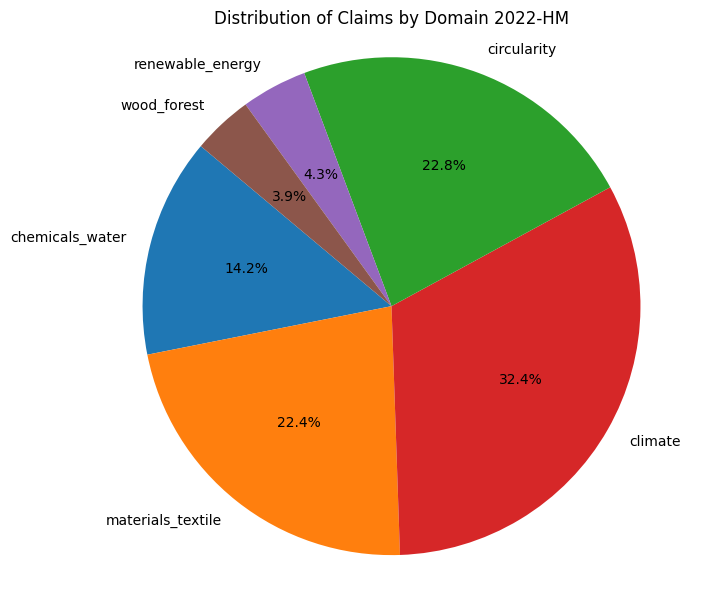

In [ ]:
# === 8A) Fixed-color pie chart for "Distribution of Claims by Domain" ===
import matplotlib.pyplot as plt
from collections import Counter

# 1)Claim order
DOMAIN_ORDER = [
    "chemicals_water",
    "materials_textile",
    "climate",
    "circularity",
    "renewable_energy",
    "wood_forest",
]
DOMAIN_COLORS = {
    "chemicals_water":  "#1f77b4",  # blue
    "materials_textile":"#ff7f0e",  # orange
    "climate":          "#d62728",  # red
    "circularity":      "#2ca02c",  # green
    "renewable_energy": "#9467bd",  # purple
    "wood_forest":      "#8c564b",  # brown
}
def color_for_domain(dom: str) -> str:
    #
    return DOMAIN_COLORS.get(dom, "#7f7f7f")  # grey

# 2) Count claim
def count_claims_by_domain():
    if "all_claims" in globals() and all_claims:
        # all_claims: list of (sentence, domain, src)
        return Counter(dom for _, dom, _ in all_claims)
    elif "G" in globals():
        # node type == "Claim",
        doms = []
        for n, data in G.nodes(data=True):
            if data.get("type") == "Claim":
                dom = data.get("domain")
                if dom:
                    doms.append(dom)
        return Counter(doms)
    else:
        raise RuntimeError("Không tìm thấy dữ liệu claims (thiếu all_claims hoặc G).")

claim_counts = count_claims_by_domain()

# 3) Lable, size
labels = [d for d in DOMAIN_ORDER if claim_counts.get(d, 0) > 0]
sizes  = [claim_counts[d] for d in labels]
colors = [color_for_domain(d) for d in labels]

# 4) Draw pie chart
plt.figure(figsize=(7, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f"{p:.1f}%",
    colors=colors,
    startangle=140,
)
plt.title("Distribution of Claims by Domain 2022-HM")
plt.axis("equal")
plt.tight_layout()
plt.show()

# 5) Color
if "G" in globals():
    for n, data in G.nodes(data=True):
        if data.get("type") == "Claim":
            dom = data.get("domain")
            if dom:
                G.nodes[n]["color"] = color_for_domain(dom)


TABLE FOR DISTRIBUTION

In [ ]:
# 7) INCONSISTENCY SCORE THEO DOMAIN
from collections import Counter

domain_counts = Counter()
for r in report:
    if (not r["safe"]) and r["inconsistent"]:
        dom = r["domain"] or "unknown"
        domain_counts[dom] += 1

print("\n=== INCONSISTENCY SCORE BY DOMAIN ===")
if domain_counts:
    # Print
    for dom, cnt in sorted(domain_counts.items(), key=lambda x: (-x[1], x[0])):
        print(f"  - {dom}: {cnt}")
else:
    print("  (no inconsistencies detected)")



=== INCONSISTENCY SCORE BY DOMAIN ===
  - climate: 90
